## **Pitchfork Album Review Exploration**
_In this kernal I will perform some basic exploration of the Pitchfork dataset including:_
* Connecting to and querying from a *sqlite* database
* Identifying top rated genres
* Visualizing score statistics by genre and over time
* Using regression to identify Pitchfork's bias by towards a genre
* Function that summarizes an artist
* Function that gives the top artist for a genre with parameters

In [1]:
#!pip install pysqlite3 --upgrade

In [2]:
# Imports and connecting to the database
import sqlite3
import pandas as pd
sqlite_file = '../input/database.sqlite'
conn = sqlite3.connect(sqlite_file)

In [3]:
# Query for a summary dataframe
q = """SELECT artists.reviewid,artists.artist,title,score,genre,year,best_new_music FROM artists 
                    INNER JOIN genres ON artists.reviewid=genres.reviewid 
                    INNER JOIN years on artists.reviewid=years.reviewid 
                    INNER JOIN reviews ON artists.reviewid=reviews.reviewid"""
df = pd.read_sql_query(q, conn)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24424 entries, 0 to 24423
Data columns (total 7 columns):
reviewid          24424 non-null int64
artist            24424 non-null object
title             24424 non-null object
score             24424 non-null float64
genre             21944 non-null object
year              23881 non-null float64
best_new_music    24424 non-null int64
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


In [4]:
# Clean up some
df.dropna(axis=0,how='any',inplace=True)
df.reset_index(inplace=True)
df.drop(labels=['index'],axis=1,inplace=True)
#df.info()
#df.describe()
df.head()

,reviewid,artist,title,score,genre,year,best_new_music
0,22703,massive attack,mezzanine,9.3,electronic,1998.0,0
1,22721,krallice,prelapsarian,7.9,metal,2016.0,0
2,22659,uranium club,all of them naturals,7.3,rock,2016.0,0
3,22661,kleenex,first songs,9.0,rock,2016.0,1
4,22661,liliput,first songs,9.0,rock,2016.0,1


              reviews
genre                
rock             9844
electronic       3996
experimental     2049
rap              1664
pop/r&b          1476
metal             920
folk/country      732
jazz              496
global            265


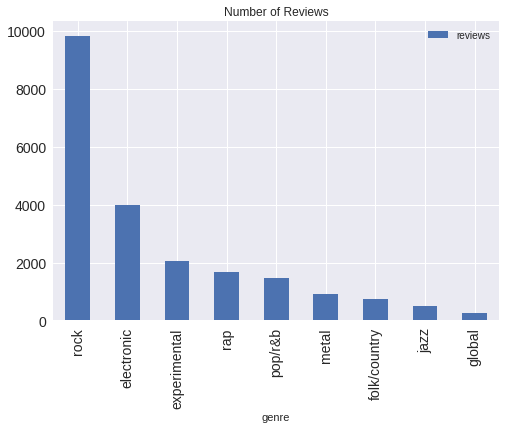

In [5]:
# Count number of reviews by genre
reviews_artist = df.groupby('artist').count().reset_index().rename(columns={'genre':'reviews'})[['artist','reviews']].set_index('artist').sort_values('reviews',ascending=False)
reviews_genre = df.groupby('genre').count().reset_index().rename(columns={'artist':'reviews'})[['genre','reviews']].set_index('genre').sort_values('reviews',ascending=False)
print(reviews_genre)
top_genres = reviews_genre.index[:5]

# Plot the data
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
reviews_genre.plot(kind='bar',fontsize=14,title='Number of Reviews')
#reviews_artist[:10].plot(kind='bar',fontsize=14)

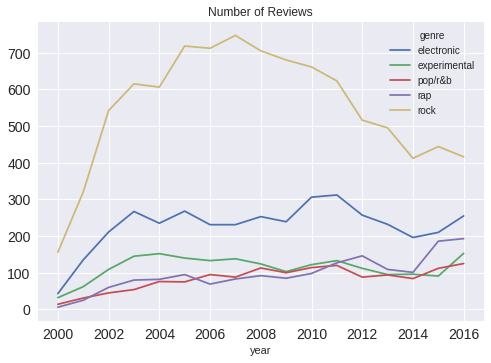

In [6]:
# Visualize number of reviews by genre over time
top_genres_boolean_mask = []
for i in range(len(df)):
    top_genres_boolean_mask.append(df['genre'][i] in top_genres)
reviews_year_genre = df[(df['year']>=2000) & (df['year']<2017) & top_genres_boolean_mask].groupby(['year','genre']).count().drop(labels='reviewid',axis=1).rename(columns={'artist':'reviews'}).sort_values(['year','reviews'],ascending=False)['reviews']
reviews_year_genre.unstack().plot(kind='line',fontsize=14,title="Number of Reviews")

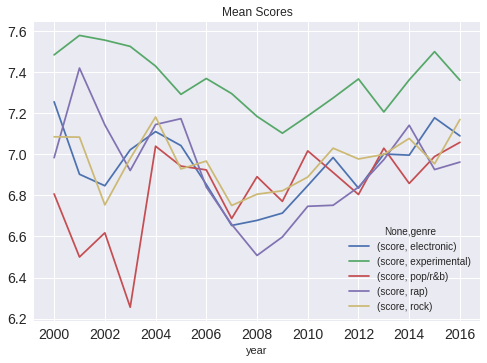

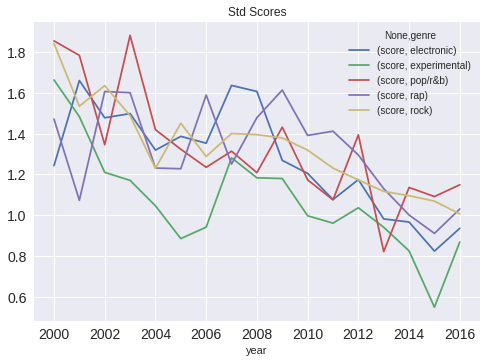

In [7]:
# Visualize mean & std dev of scores by genre over time
top_genres_boolean_mask = []
for i in range(len(df)):
    top_genres_boolean_mask.append(df['genre'][i] in top_genres)
top_genres_boolean_mask = (df['year']>=2000) & (df['year']<2017) & top_genres_boolean_mask

reviews_score_mean = df[top_genres_boolean_mask].groupby(['year','genre']).mean().drop(labels='reviewid',axis=1)[['score']].sort_values(['year','score'],ascending=False)
reviews_score_std = df[top_genres_boolean_mask].groupby(['year','genre']).std().drop(labels='reviewid',axis=1)[['score']].sort_values(['year','score'],ascending=False)
reviews_score_mean.unstack().plot(kind='line',fontsize=14,title='Mean Scores')
reviews_score_std.unstack().plot(kind='line',fontsize=14,title='Std Scores')

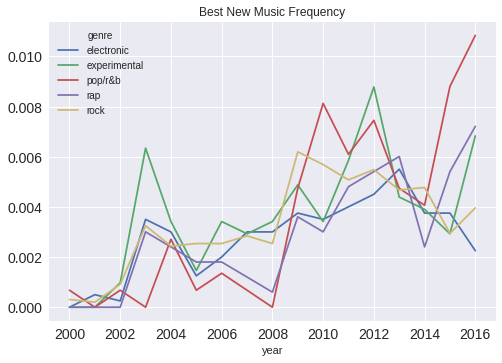

In [8]:
# Visualize frequency of best new music by genre
top_genres_boolean_mask = []
for i in range(len(df)):
    top_genres_boolean_mask.append(df['genre'][i] in top_genres)
top_genres_boolean_mask = (df['year']>=2000) & (df['year']<2017) & top_genres_boolean_mask
bnm_freq = df[top_genres_boolean_mask].groupby(['year','genre']).sum()['best_new_music']/df.groupby('genre').count()['best_new_music']
bnm_freq.unstack().plot(kind='line',fontsize=14,title='Best New Music Frequency')

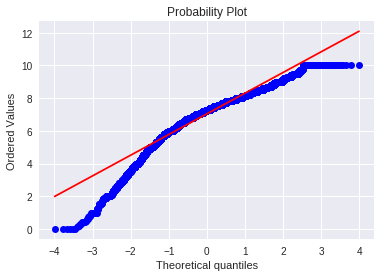

In [9]:
# Are scores normally distributed??
import numpy as np 
import pylab 
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('seaborn')
%matplotlib inline
   
stats.probplot(df['score'], dist="norm", plot=pylab)
pylab.show()

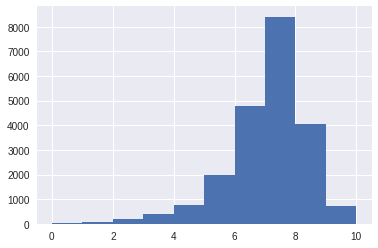

In [10]:
# Apparently not...
df['score'].hist()

In [11]:
# Create Dummy Variable columns for linear regression
df_dummies = pd.get_dummies(data=df,columns=['genre'],drop_first=True)
df_dummies.columns

Index(['reviewid', 'artist', 'title', 'score', 'year', 'best_new_music',
       'genre_experimental', 'genre_folk/country', 'genre_global',
       'genre_jazz', 'genre_metal', 'genre_pop/r&b', 'genre_rap',
       'genre_rock'],
      dtype='object')

In [12]:
# Can score be predicted from year and genre?
import statsmodels.api as sm
x = df_dummies[['year','genre_experimental', 'genre_folk/country', 'genre_global',
       'genre_jazz', 'genre_metal', 'genre_pop/r&b', 'genre_rap',
       'genre_rock']]
y = df_dummies['score']
model = sm.OLS(y,x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                 6.933e+04
Date:                Thu, 07 Feb 2019   Prob (F-statistic):               0.00
Time:                        07:44:58   Log-Likelihood:                -36127.
No. Observations:               21442   AIC:                         7.227e+04
Df Residuals:                   21433   BIC:                         7.234e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
year                   0.0035   1.03e-05    336.668      0.000       0.003       0.003
genre_experimental     0.4304      0.035     12.140      0.000       0.361       0.500
genre_folk/country     0.2717      0.052      5.179      0.000       0.169       0.375
genre_global           0.5213      0.083      6.298      0.000       0.359       0.684
genre_jazz             0.4420      0.062      7.116      0.000       0.320       0.564
genre_metal            0.0285      0.048      0.598      0.550      -0.065       0.122
genre_pop/r&b         -0.0189      0.040     -0.475      0.635      -0.097       0.059
genre_rap             -0.0308      0.038     -0.808      0.419      -0.105       0.044
genre_rock             0.0546      0.024      2.233      0.026       0.007       0.103
==============================================================================
Omnibus:                     4396.931   Durbin-Watson:                   1.467
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10486.947
Skew:                          -1.149   Prob(JB):                         0.00
Kurtosis:                       5.540   Cond. No.                     1.93e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.93e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
# A slimmer model only including significant predictors
import statsmodels.api as sm
x = df_dummies[['year','genre_experimental', 'genre_folk/country', 'genre_global',
       'genre_jazz','genre_rock']]
y = df_dummies['score']
model_2= sm.OLS(y,x).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                 1.040e+05
Date:                Thu, 07 Feb 2019   Prob (F-statistic):               0.00
Time:                        07:44:58   Log-Likelihood:                -36128.
No. Observations:               21442   AIC:                         7.227e+04
Df Residuals:                   21436   BIC:                         7.232e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
year                   0.0035   7.24e-06    477.691      0.000       0.003       0.003
genre_experimental     0.4370      0.032     13.536      0.000       0.374       0.500
genre_folk/country     0.2782      0.050      5.524      0.000       0.180       0.377
genre_global           0.5278      0.081      6.480      0.000       0.368       0.688
genre_jazz             0.4485      0.060      7.431      0.000       0.330       0.567
genre_rock             0.0612      0.020      3.123      0.002       0.023       0.100
==============================================================================
Omnibus:                     4392.039   Durbin-Watson:                   1.468
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10458.631
Skew:                          -1.149   Prob(JB):                         0.00
Kurtosis:                       5.535   Cond. No.                     1.84e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### **The regression results suggest two things about Pitchfork review scores:**
* Over time,  reviews tend to be scored higher.  **Each year is 0.0035 higher** on average than the previous one.
* The most favored genres in order are:
    1. **Global [0.5278]**
    1. **Jazz [0.4485]**
    1. **Experimental [0.4370]**
    1. **Folk/Country [0.2782]**
    1. **Rock [0.0612]**

In [14]:
# Returns the average scores of a list of arists, weighted equally
# Expand to give full artist summary
def score_artists(artists_list):
    cum_score = 0
    for artist in artists_list:
        cum_score += df[df['artist']==artist]['score'].mean()
    return cum_score/len(artists_list)

my_artists = ['david bowie','prince','led zeppelin']
pop_artists = ['ariana grande','sza','justin bieber']
print(score_artists(my_artists),score_artists(pop_artists))

7.95787037037037 6.455555555555556


In [15]:
# Returns a list of the top n artists in a genre by mean album score or best new music freq
# Genres are 'electronic', 'metal', 'rock', 'rap', 'experimental', 'pop/r&b','folk/country', 'jazz', 'global'
# Method is either 'best', 'score', or 'both'
def top_genre_artists(genre,method='both',n=5,min_albums=3,year=2000):
    if genre not in df['genre'].unique():
        print('Invalid genre')
        return []
    elif method not in ['best','score','both']:
        print('Invalid method')
        return []
    print('The top '+str(n)+' artists in '+genre+' are:')
    if method == 'score':
        print('(Ranked by score, '+str(min_albums)+' album minimum)')
        artist_grouped = df[(df['genre']==genre) & (df['year']>=year)].groupby('artist')
        return artist_grouped.mean()[artist_grouped.size()>=min_albums]['score'].sort_values(ascending=False)[:n]
    if method == 'best':
        print('(Ranked by best new music frequency, '+str(min_albums)+' album minimum)')
        artist_grouped = df[(df['genre']==genre) & (df['year']>=year)].groupby('artist')
        return artist_grouped.mean()[artist_grouped.size()>=min_albums]['best_new_music'].sort_values(ascending=False)[:n]
    if method == 'both':
        print('(Ranked by score * best new music frequency, '+str(min_albums)+' album minimum)')
        artist_grouped = df[(df['genre']==genre) & (df['year']>=year)].groupby('artist')
        score = artist_grouped.mean()[artist_grouped.size()>=min_albums]['score']
        best = artist_grouped.mean()[artist_grouped.size()>=min_albums]['best_new_music']
        return (best*score).sort_values(ascending=False)[:n]

#top_genre_artists('electronic','score')
top_genre_artists('rock')

# THERE IS A SLIGHT PROBLEM WITH THIS METHOD BECAUSE REISSUED ALBUM REVIEWS APPEAR TWICE
#   -> DISTORTING THE MIN ALBUM REQUIREMENT, WILL TRY TO FIND A SOLUTION
# MULTI-GENRE REVIEWS ALSO APPEAR TWICE BUT ARE FILTERED SO NO PROBLEM

The top 5 artists in rock are:
(Ranked by score * best new music frequency, 3 album minimum)


artist
girls              9.033333
tame impala        8.933333
fleet foxes        8.833333
iceage             8.500000
vampire weekend    6.506250
dtype: float64

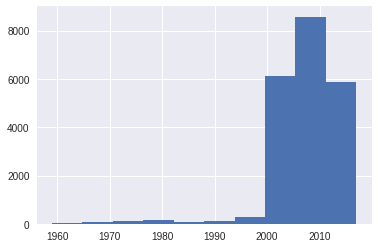

In [16]:
df['year'].hist()
# Will explore further...